- 📈 Factor investing began with Fama-French and CAPM research, identifying micro-factors like excess market returns, value vs. growth, and small vs. large cap stocks.
- 🧪 Researchers used OLS regression to measure each factor’s influence on individual stock returns.
- 📊 Over time, 50+ factors have emerged, tracked by firms like MSCI for portfolio analysis.
- 🧩 After the 2008 crash, macro-factors became central to assessing complex hybrid investments (e.g. hedge funds, private equity).
- 🌍 Harvard's endowment uses five macro-factors: global equity, U.S. bonds, high-yield bonds, inflation hedging, and currency hedging.
- 🤖 In machine learning terms, factors are like features—used to forecast market conditions.
- 🔧 Regularized regression with penalty terms is used to shrink factor loadings, improving forecast accuracy.
- ✅ Cross-validation helps optimize the penalty value when estimating expected asset returns.


## Linear Model:

\begin{equation*}
    y_t = {X_t}^T \beta + \epsilon_t
\end{equation*}

- $t$ is index
- ${\bf y} = \{y_t\}$ is the dependent variable for observation $t$
- ${X_t}^T = (X_t^1, X_t^2, \dots, X_t^m)$ is our set of factors (independent variables)
- ${\bf \beta} = (\beta_1,\dots,\beta_m)'$ are our coefficients (transposed) (factor loadings)

We can estimate ${\bf \beta}$ by using OLS (Ordinary Least Squares):
\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - {X_t}^T {\bf \beta})^2 \bigg\}.
\end{equation*}


In this example, we are interested in explaining the asset returns with a five-factor model:

1) World Equities: MSCI All World market capitalization weighted index.

2) 10 Year US Treasury: Return of 10 year US Treasury Bond

3) High Yield: BOFA Merrill Lynch Global High Yield Index

4) Inflation Protection: This is a "style" factor that considers the difference between real and nominal returns, thus balances the need for both.  It's the return of the TIPS bond minus the a weighted average of Treasury Bonds.

5) Currency Protection: This is also an exchange rate factor, capturing the value of the dollar versus a basket of foreign currencies.

In [ ]:
#Path for data
dataPath = 'https://github.com/nick-dahl/AI_Finance/blob/main/Data2016.csv?raw=true'

#Define the factor names
factorName = ['World Equities', '10-year US Treasuries', 'High Yield', 'Inflation Protection', 'Currency Protection']

#Names of assets
assetName = ['SP500 Total Return','International Equity','U.S. Treasury 20 years', 'Corporate Bond','Real Estate', 'Commodity', 'TIPS']

#Name of date column
dateName = 'Date'

#User Analysis Section.  Change the variables in this section to run user specific analysis
#isDemo is a boolean variable, set to True if the user wants to run custom analysis
isDemo = False

#dataPathUser: Path to User Defined Data
dataPathUser = 'https://github.com/nick-dahl/AI_Finance/blob/main/Data2016.csv?raw=true'

#factorNameUser: List, defines the factors
factorNameUser = ['World Equities', '10-year US Treasuries', 'High Yield', 'Inflation Protection', 'Currency Protection']

#assetNameUser: List, defines the asset to be used
assetNameUser = 'Commodity'

#dateName: string, date column
dateNameUser = 'Date'

#lambdaHatUser: float, penalty term of user define LASSO regression
lambdaHatUser = .00005

#Start and End Dates for the Analysis
startDateUser = '1997-03-01'
endDateUser = '2014-12-01'

#Stuff for optional part of user section

#Best Subset Regression Related
maxVarsUser = 1

#Elastic Net Related
numL1RatioUser = 10
numAlphasUser = 20

In [4]:
#@title Library for Factor-Model usage

#Library for Factor-Model usage


import numpy as np #for numerical array data
import pandas as pd #for tabular data
from scipy.optimize import minimize
import matplotlib.pyplot as plt #for plotting purposes
import time

import cvxpy as cp
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#Plotting Functions
def plot_returns(data, names, flag='Total Return', date='Date', printFinalVals = False):
    '''plot_returns returns a plot of the returns
    INPUTS:
        names: string, name of column to be plotted, or list, in which case it plots all of them
        data: pd dataframe, where the data is housed
        flag: string, Either Total Return or Monthly Return
        date: string, column name corresponding to the date variable
        printFinalVals: Boolean, if True, prints the final Total Return
    Outputs:
        a plot'''
    #Clean Inputs:
    if(date not in data.columns):
        print ('date column not in the pandas df')
        return
    if(type(names) is str):
        names = [names]
    for name in names:
        if(name not in data.columns):
            print ('column ' + name + ' not in pandas df')
            return
    #If the inputs are clean, create the plot
    data = data.sort_values(date).copy()
    data.reset_index(drop=True, inplace=True)
    data[date] = pd.to_datetime(data[date])

    if (flag == 'Total Return'):
        n = data.shape[0]
        totalReturns = np.zeros((n,len(names)))
        totalReturns[0,:] = 1.
        for i in range(1,n):
            totalReturns[i,:] = np.multiply(totalReturns[i-1,:], (1+data[names].values[i,:]))
        for j in range(len(names)):
            plt.semilogy(data[date], totalReturns[:,j])

        plt.title('Total Return Over Time')
        plt.ylabel('Total Return')
        plt.legend(names)
        plt.xlabel('Date')
        plt.show()
        if(printFinalVals):
            print(totalReturns[-1])
    elif (flag == 'Return'):
        for i in range(len(names)):
            plt.plot(data[date], data[names[i]])
        plt.title('Returns Over Time')
        plt.ylabel('Returns')
        plt.legend(names)
        plt.xlabel('Date')
        plt.show()
    else:
        print ('flag variable must be either Total Return or Return')


#Helper Functions
def create_options():
    '''create standard options dictionary to be used as input to regression functions'''
    options = dict()
    options['time_period'] = 'all'
    options['date'] = 'Date'
    options['return_model'] = False
    options['print_loadings'] = True
    return options

def create_options_lasso():
    options = create_options()
    options['lambda_hat'] = .5
    return options

def create_options_ridge():
    options = create_options()
    options['lambda'] = 1
    return options

def create_options_cv_lasso():
    options = create_options()
    options['max_lambda_hat'] = 1
    options['n_lambda_hat'] = 200
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_cv_ridge():
    options = create_options()
    options['max_lambda'] = 1
    options['n_lambda'] = 100
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_cv_elastic_net():
    options = create_options()
    options['max_lambda_hat'] = 1
    options['max_l1_ratio'] = .99
    options['n_lambda_hat'] = 100
    options['n_l1_ratio'] = 20
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_best_subset():
    '''create standard options dictionary to be used as input to regression functions'''
    options = create_options()
    options['return_model'] = False
    options['print_loadings'] = True
    options['max_vars'] = 3
    return options


def create_dictionary_for_analysis(method, methodDict=None):
    '''create_dictionary_for_anlsis creates the options dictionary that can be used as an input to a factor model
    INPUTS:
        method: string, defines the method
    OUTPUTS:
        methodDict: dictionary, keys are specific options the user wants to specify, values are the values of those options
    '''
    if(method == 'OLS'):
        options = create_options()
    elif(method == 'CVLasso'):
        options = create_options_cv_lasso()
    elif(method == 'CVRidge'):
        options = create_options_cv_ridge()
    elif(method == 'CVElasticNet'):
        options = create_options_cv_elastic_net()
    elif(method == 'BestSubset'):
        options = create_options_best_subset()
    elif(method == 'RelaxedLasso'):
        options = create_options_relaxed_lasso()
    else:
        print('Bad Method Specification for Train')
        return
    options['returnModel'] = True
    options['printLoadings'] = False
    options['date'] = 'DataDate'
    for key in methodDict:
        options[key] = methodDict[key]
    return options



def print_timeperiod(data, dependentVar, options):
    '''print_timeperiod takes a a dependent varaible and a options dictionary, prints out the time period
    INPUTS:
        data: pandas df, df with the data
        dependentVar: string, name of dependent variable
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
    OUTPUTS:
        printed stuff
    '''
    print ('Dependent Variable is ' + dependentVar)
    if(options['time_period'] == 'all'):
        sortedValues = data.sort_values(options['date'])[options['date']].reset_index(drop=True)
        n = sortedValues.shape[0]
        beginDate = sortedValues[0]
        endDate = sortedValues[n-1]
        print ('Time period is between ' + num_to_month(beginDate.month) +  ' ' + str(beginDate.year) + ' to ' + num_to_month(endDate.month) +  ' ' + str(endDate.year) + ' inclusive   ')        
    else:
        print ('Time period is ' + options['timeperiod'])

def display_factor_loadings(intercept, coefs, factorNames, options):
    '''display_factor_loadings takes an intercept, coefs, factorNames and options dict, and prints the factor loadings in a readable way
    INPUTS:
        intercept: float, intercept value
        coefs: np array, coeficients from pandas df
        factorNames: list, names of the factors
        options: dict, should contain at least one key, nameOfReg
            nameOfReg: string, name for the regression
    Outputs:
        output is printed
    '''
    loadings = np.insert(coefs, 0, intercept)
    if('name_of_reg' not in options.keys()):
        name = 'No Name'
    else:
        name = options['name_of_reg']
    out = pd.DataFrame(loadings, columns=[name])
    out = out.transpose()
    fullNames = ['Intercept'] + factorNames
    out.columns = fullNames
    print(out)

def best_subset(x,y,l_0):
    # Mixed Integer Programming in feature selection
    M = 1000
    n_factor = x.shape[1]
    z = cp.Variable(n_factor, boolean=True)
    beta = cp.Variable(n_factor)
    alpha = cp.Variable(1)

    def MIP_obj(x,y,b,a):
        return cp.norm(y-cp.matmul(x,b)-a,2)

    best_subset_prob = cp.Problem(cp.Minimize(MIP_obj(x, y, beta, alpha)), 
                             [cp.sum(z)<=l_0, beta+M*z>=0, M*z>=beta])
    best_subset_prob.solve(solver='ECOS_BB')
    return alpha.value, beta.value


#First function, linear factor model build
def linear_regression(data, dependentVar, factorNames, options):
    '''linear_regression takes in a dataset and returns the factor loadings using least squares regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    linReg = LinearRegression(fit_intercept=True)
    linReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        # Now print the factor loadings
        display_factor_loadings(linReg.intercept_, linReg.coef_, factorNames, options)

    if(options['return_model']):
        return linReg


def lasso_regression(data, dependentVar, factorNames, options):
    '''lasso_regression takes in a dataset and returns the factor loadings using lasso regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            printLoadings: boolean, if true, prints the coeficients

            date: name of datecol
            returnModel: boolean, if true, returns model
            alpha: float, alpha value for LASSO regression
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    if('lambda_hat' not in options.keys()):
        print ('lambda_hat not specified in options')
        return

    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    lassoReg = Lasso(alpha=options['lambda_hat'], fit_intercept=True)
    lassoReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('lambda_hat = ' + str(options['lambda_hat']))

        #Now print the factor loadings
        display_factor_loadings(lassoReg.intercept_, lassoReg.coef_, factorNames, options)

    if(options['return_model']):
        return lassoReg

def ridge_regression(data, dependentVar, factorNames, options):
    '''ridge_regression takes in a dataset and returns the factor loadings using ridge regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            lambda: float, alpha value for Ridge regression
            printLoadings: boolean, if true, prints the coeficients
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    if('lambda' not in options.keys()):
        print ('lambda not specified in options')
        return

    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    ridgeReg = Ridge(alpha=options['lambda'], fit_intercept=True)
    ridgeReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('lambda = ' + str(options['lambda']))

        #Now print the factor loadings
        display_factor_loadings(ridgeReg.intercept_, ridgeReg.coef_, factorNames, options)

    if(options['return_model']):
        return ridgeReg

def best_subset_regression(data, dependentVar, factorNames, options):
    '''best_subset_regression takes in a dataset and returns the factor loadings using best subset regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            maxVars: int, maximum number of factors that can have a non zero loading in the resulting regression
            printLoadings: boolean, if true, prints the coeficients
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Check dictionary for maxVars option
    if('max_vars' not in options.keys()):
        print ('max_vars not specified in options')
        return

    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    alpha, beta = best_subset(data[factorNames].values, data[dependentVar].values, options['max_vars'])
    #round beta values to zero
    beta[np.abs(beta) <= 1e-7] = 0.0
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Max Number of Non-Zero Variables is ' + str(options['max_vars']))

        #Now print the factor loadings
        display_factor_loadings(alpha, beta, factorNames, options)

    if(options['return_model']):
        out = LinearRegression()
        out.intercept_ = alpha[0]
        out.coef_ = beta
        return out

def cross_validated_lasso_regression(data, dependentVar, factorNames, options):
    '''cross_validated_lasso_regression takes in a dataset and returns the factor loadings using lasso regression and cross validating the choice of lambda
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphas = np.logspace(-12, np.log(options['max_lambda_hat']), base=np.exp(1), num=options['n_lambda_hat'])
    #alphas = np.linspace(1e-12, alphaMax, options['nAlphas'])
    if(options['random_state'] == 'none'):
        lassoTest = Lasso(fit_intercept=True)
    else:
        lassoTest = Lasso(random_state = options['random_state'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(lassoTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    lassoBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best lambda_hat = ' + str(alphaBest))
        #Now print the factor loadings
        display_factor_loadings(lassoBest.intercept_, lassoBest.coef_, factorNames, options)

    if(options['return_model']):
        return lassoBest

def cross_validated_ridge_regression(data, dependentVar, factorNames, options):
    '''cross_validated_ridge_regression takes in a dataset and returns the factor loadings using ridge regression and choosing lambda via ridge regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphaMax = options['max_lambda']
    alphas = np.logspace(-12, np.log(alphaMax), num=options['n_lambda'], base=np.exp(1))
    if(options['randomState'] == 'none'):
        ridgeTest = Ridge(fit_intercept=True)
    else:
        ridgeTest = Ridge(random_state = options['randomState'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(ridgeTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    ridgeBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best Lambda = ' + str(alphaBest))
        #Now print the factor loadings
        display_factor_loadings(ridgeBest.intercept_, ridgeBest.coef_, factorNames, options)

    if(options['return_model']):
        return ridgeBest

def cross_validated_elastic_net_regression(data, dependentVar, factorNames, options):
    '''cross_validated_elastic_net_regression takes in a dataset and returns the factor loadings using elastic net, also chooses alpha and l1 ratio via cross validation
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            maxL1Ratio: float
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphaMax = options['max_lambda_hat']
    alphas = np.logspace(-12, np.log(alphaMax), num=options['n_lambda_hat'])
    l1RatioMax = options['max_l1_ratio']
    l1Ratios = np.linspace(1e-6, l1RatioMax, options['n_l1_ratio'])
    if(options['random_state'] == 'none'):
        elasticNetTest = ElasticNet(fit_intercept=True)
    else:
        elasticNetTest = ElasticNet(random_state = options['random_state'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas, 'l1_ratio': l1Ratios}]

    clf = GridSearchCV(elasticNetTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    elasticNetBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']
    l1RatioBest = clf.best_params_['l1_ratio']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best lambda_hat = ' + str(alphaBest))
        print('Best l1 ratio = ' + str(l1RatioBest))
        #Now print the factor loadings
        display_factor_loadings(elasticNetBest.intercept_, elasticNetBest.coef_, factorNames, options)

    if(options['return_model']):
        return elasticNetBest


def run_factor_model(data, dependentVar, factorNames, method, options):
    '''run_Factor_model allows you to specify the method to create a model, returns a model object according to the method you chose
    INPUTS:
        data: pandas df, must contain the columns specified in factorNames and dependentVar
        dependentVar: string, dependent variable
        factorNames: list of strings, names of independent variables
        method: string, name of method to be used.  Supports OLS, LASSO, CVLASSO atm
        options: dictionary object, controls the hyperparameters of the method
    Outputs:
        out: model object'''

    #Make sure the options dictionary has the correct settings
    options['return_model'] = True
    options['print_loadings'] = False

    #Now create the appropriate model
    if (method == 'OLS'): #run linear model
        return linear_regression(data, dependentVar, factorNames, options)
    if (method == 'LASSO'):
        return lasso_regression(data, dependentVar, factorNames, options)
    if (method == 'Ridge'):
        return ridge_regression(data, dependentVar, factorNames, options)
    if (method == 'CVLasso'):
        return cross_validated_lasso_regression(data, dependentVar, factorNames, options)
    if (method == 'CVRidge'):
        return cross_validated_ridge_regression(data, dependentVar, factorNames, options)
    if (method == 'CVElasticNet'):
        return cross_validated_elastic_net_regression(data, dependentVar, factorNames, options)
    if (method == 'BestSubset'):
        return best_subset_regression(data, dependentVar, factorNames, options)
    else:
        print ('Method ' + method + ' not supported')

# Function to create a time series of factor loadings using a trailing window
def compute_trailing_factor_regressions(data, dependentVar, factorNames, window, method, options, dateCol='Date', printTime=False):
    '''compute_trailing_factor_regressions computes the factor regresssions using a trailing window, returns a pandas df object
    INPUTS:
        data: pandas df, must constain the columns dependentVar, and the set of columns factorNames
        dependentVar: string, names the dependent variable, must be a column in the dataframe data
        factorNames: list of string, elements must be members
        window: int, lookback window, measured in number of trading days
        method: string, can be OLS, LASSO or CVLasso
        options: dictionary, options dictionary
        dateCol: string, name of date column, also must be included in data
        printTime: boolean, if True, prints time it took to run the regressions
    Outputs:
        regressionValues: pandas df, rows should be different dates, columns should be factor loadings calculated using the trailing window
    '''
    if(printTime):
        start = time.time()
    options['return_model'] = True
    options['print_loadings'] = False
    days = list(np.sort(data[dateCol].unique()))
    listOfFactorsAndDate = [dateCol] + factorNames
    regressionValues = pd.DataFrame(columns=listOfFactorsAndDate)
    for i in range(window, len(days)):
        #Filter the data
        filtered = data[(data[dateCol] <= days[i]) & (data[dateCol] >= days[i-window])]
        #Run the regression
        reg = run_factor_model(filtered, dependentVar, factorNames, method, options)
        #Append the regression values
        newRow = pd.DataFrame(reg.coef_)
        newRow = newRow.transpose()
        newRow.columns = factorNames
        newRow[dateCol] = days[i]
        regressionValues = regressionValues.append(newRow, sort=True)
    if(printTime):
        print('regression took ' + str((time.time() - start)/60.) + ' minutes')
    return regressionValues

#Asorted Nonsense
def num_to_month(month):
    #num to month returns the name of the month, input is an integer
    if (month==1):
        return 'January'
    if (month==2):
        return 'Febuary'
    if (month==3):
        return 'March'
    if (month==4):
        return 'April'
    if (month==5):
        return 'May'
    if (month==6):
        return 'June'
    if (month==7):
        return 'July'
    if (month==8):
        return 'August'
    if (month==9):
        return 'September'
    if (month==10):
        return 'October'
    if (month==11):
        return 'November'
    if (month==12):
        return 'December'


def data_time_periods(data, dateName):
    '''data_time_periods figures out if the data is daily, weekly, monthly, etc
    INPUTS:
        data: pandas df, has a date column in it with column name dateName
        dateName: string, name of column to be analysed
    '''
    secondToLast = data[dateName].tail(2)[:-1]
    last = data[dateName].tail(1)
    thingy = (last.values - secondToLast.values).astype('timedelta64[D]') / np.timedelta64(1, 'D')
    thingy = thingy[0]
    if (thingy > 200):
        return 'yearly'
    elif(thingy > 20):
        return 'monthly'
    elif(thingy > 5):
        return 'weekly'
    else:
        return 'daily'

In [5]:
from sklearn.metrics import r2_score

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import importlib as imp
import warnings
warnings.filterwarnings('ignore')

Reading our data and getting the assets/factors

In [6]:
all_data = pd.read_csv(dataPath)
all_data[dateName] = pd.to_datetime(all_data[dateName])
all_data = all_data[all_data['Date'] <= '2014-12-01'].copy() 

In [7]:
all_data[['Real Estate'] + factorName].head(5)

,Real Estate,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection
0,-0.014847,-0.020349,0.022922,0.032048,0.006524,-0.003404
1,0.032460,0.010680,0.030014,0.013531,-0.038375,-0.020587
2,-0.005961,0.045804,0.007195,0.025871,-0.023184,-0.042060
3,0.002259,0.036372,0.016973,0.030836,-0.003600,-0.015827
4,0.045025,0.011040,0.054900,0.006743,-0.054282,0.009121


In [8]:
data_time_periods(all_data, dateName)

'monthly'

In [9]:
startDate = all_data[dateName].min()
endDate = all_data[dateName].max()

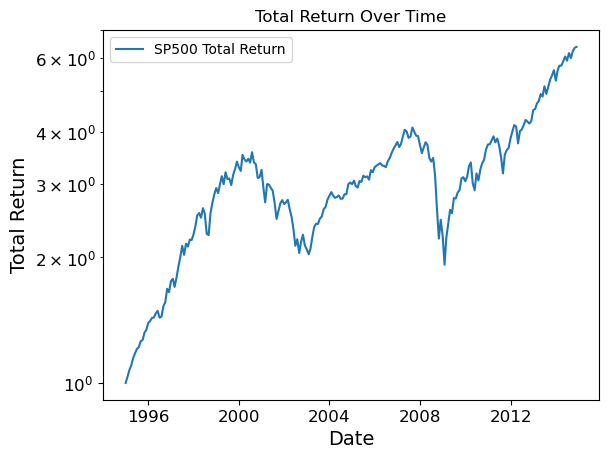

In [10]:
name = 'SP500 Total Return' #name can be changed to any of the factors
plot_returns(all_data, name, flag='Total Return')

In [11]:
pd.options.display.float_format = "{:,.3f}".format #This rounds the display output to 3 decimals
all_data.sort_values('SP500 Total Return').head(3)
#this makes sense as all 3 months were part of the great financial crisis of 2008-2009

,Date,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection,U.S. Equity,SP500 Total Return,S&P 500,International Equity,U.S. Treasury 20 years,Corporate Bond,Real Estate,Commodity,TIPS
165,2008-10-01,-0.194,-0.029,-0.084,-0.058,0.087,-0.173,-0.166,-0.168,-0.205,-0.036,-0.070,-0.312,-0.295,-0.087
166,2008-11-01,-0.132,0.085,0.075,-0.078,0.006,-0.163,-0.152,-0.072,-0.112,0.144,0.045,-0.337,-0.176,0.007
169,2009-02-01,-0.131,-0.002,0.033,-0.018,0.028,-0.148,-0.148,-0.106,-0.127,-0.004,-0.019,-0.269,-0.097,-0.020


\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - {X_t}^T {\bf \beta})^2 \bigg\}
\end{equation*}

In our notation, n in the number of data points.  In this case, OLS regression has a closed form solution.

\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = ({\bf X}^\intercal {\bf X})^{-1} {\bf X}^\intercal{\bf Y}
\end{equation*}

Where ${\bf Y}$ is the vector representation of $y_t$, and ${\bf X}$ is the matrix representation of $X_t$

In [12]:
# Linear Regression (OLS)
Factors = all_data[factorName].values
Assets = all_data[assetName].values

Asset_RE = Assets[:,0]
Factors_ones = np.concatenate((np.ones((all_data.shape[0],1)),Factors),axis=1)
#theory_beta implements the actual equation for OLS
theory_beta = np.linalg.inv(Factors_ones.T.dot(Factors_ones)).dot(Factors_ones.T).dot(Asset_RE)
print('Dependent variable is SP500 Total Return')
print('Historical Timeperiods ' +  num_to_month(startDate.month) +  " " + str(startDate.year) + " "
      + num_to_month(endDate.month) +  " " + str(endDate.year))
opt = dict()
opt['name_of_reg'] = 'theory_beta'
display_factor_loadings(theory_beta[0], theory_beta[1:], factorName, opt)

Dependent variable is SP500 Total Return
Historical Timeperiods January 1995 December 2014
             Intercept  World Equities  10-year US Treasuries  High Yield  \
theory_beta      0.001           1.021                  0.128      -0.004   

             Inflation Protection  Currency Protection  
theory_beta                -0.011                0.397  


In [13]:
#Linear Regression via Scikit-learn
options = create_options()
options['name_of_reg'] = 'sikit-learn OLS'
linear_regression(all_data, 'SP500 Total Return', factorName, options)

Dependent Variable is SP500 Total Return
Time period is between January 1995 to December 2014 inclusive   
                 Intercept  World Equities  10-year US Treasuries  High Yield  \
sikit-learn OLS      0.001           1.021                  0.128      -0.004   

                 Inflation Protection  Currency Protection  
sikit-learn OLS                -0.011                0.397  


OLS is very unstable - does not generalize well for future data
1. Factors exceed # of asset categories
2. No regime awareness (loadings are not constant over time)

In [14]:
all_data[factorName].corr()

,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection
World Equities,1.000,-0.176,0.308,0.332,-0.528
10-year US Treasuries,-0.176,1.000,0.131,-0.616,-0.140
High Yield,0.308,0.131,1.000,0.005,-0.185
Inflation Protection,0.332,-0.616,0.005,1.000,-0.209
Currency Protection,-0.528,-0.140,-0.185,-0.209,1.000


Regime Dependence (relationships between variables, effects of shocks, and overall behavior is depending on which regime is active)

Factor loadings using full dataset, normal regime, and crash regime

In [15]:
options = create_options()
options['name_of_reg'] = 'OLS full data'
options['return_model'] = False
linear_regression(all_data, 'SP500 Total Return', factorName, options)

Dependent Variable is SP500 Total Return
Time period is between January 1995 to December 2014 inclusive   
               Intercept  World Equities  10-year US Treasuries  High Yield  \
OLS full data      0.001           1.021                  0.128      -0.004   

               Inflation Protection  Currency Protection  
OLS full data                -0.011                0.397  


In [16]:
options = create_options()
normal_data = all_data[all_data['SP500 Total Return'] > 0].copy()
options['name_of_reg'] = 'OLS Normal'
options['return_model'] = False
linear_regression(normal_data, 'SP500 Total Return', factorName, options)

Dependent Variable is SP500 Total Return
Time period is between January 1995 to December 2014 inclusive   
            Intercept  World Equities  10-year US Treasuries  High Yield  \
OLS Normal      0.007           0.913                  0.201       0.025   

            Inflation Protection  Currency Protection  
OLS Normal                -0.003                0.388  


In [17]:
options = create_options()
crash_data = all_data[all_data['SP500 Total Return'] <= 0].copy()
options['name_of_reg'] = 'OLS Crash'
options['return_model'] = False
linear_regression(crash_data, 'SP500 Total Return', factorName, options)

Dependent Variable is SP500 Total Return
Time period is between July 1996 to September 2014 inclusive   
           Intercept  World Equities  10-year US Treasuries  High Yield  \
OLS Crash     -0.009           0.822                  0.065      -0.004   

           Inflation Protection  Currency Protection  
OLS Crash                 0.159                0.229  


You can see that during the crash period 10-year US Trasuries is near 0, while in a "normal" period it was 0.2.

Building Baseline OLS Model for our training set:

In [18]:
#breakpoint is December 2012, so train is from 3/1/1997 - 12/1/2012, and everything after that will be used for test

train = all_data[(all_data['Date'] <= '2012-12-01') & (all_data['Date'] >= '1997-03-01')].copy()
test = all_data[all_data['Date'] > '2012-12-01'].copy()

In [19]:
options = create_options()
options['name_of_reg'] = 'OLS full data'
options['return_model'] = True
ols_model_train = linear_regression(train, 'SP500 Total Return', factorName, options)

Dependent Variable is SP500 Total Return
Time period is between March 1997 to December 2012 inclusive   
               Intercept  World Equities  10-year US Treasuries  High Yield  \
OLS full data     -0.000           1.007                  0.132      -0.000   

               Inflation Protection  Currency Protection  
OLS full data                 0.058                0.374  


Replicating the Harvard 5 Factor study:

In [20]:
names = assetName

expected_returns = pd.DataFrame(np.array([[.08/12, .02/12, .05/12, -.003/12, 0/12]]), columns=factorName)

factor_matrix = pd.DataFrame(np.zeros((4, 7)), columns=['Intercept'] + factorName + 
                          ['Implied Expected (Annual) Return'])

for i in range(len(names)):
    options = create_options_cv_lasso()
    options['name_of_reg'] = 'CV Lasso'
    options['max_lambda_hat'] = .001 #This specifies the maximum Alpha value tested by cross validation, minimum value is zero
    options['return_model'] = True
    options['print_loadings'] = False
    options['n_folds'] = 5 #This states the number of folds
    data = all_data[[names[i]] + factorName + ['Date']].copy()
    data = data[(data['Date'] >= '1997-03-01') & (data['Date'] <= '2012-12-01')].copy()
    data = data.dropna()
    model = cross_validated_lasso_regression(data, names[i], factorName, options)
    
    factor_matrix.loc[i,'Intercept'] = model.intercept_
    factor_matrix.loc[i, factorName] = model.coef_
    factor_matrix.loc[i, 'Implied Expected (Annual) Return'] = 12*model.predict(expected_returns)
    
factor_matrix.index = names

In [21]:
factor_matrix

,Intercept,World Equities,10-year US Treasuries,High Yield,Inflation Protection,Currency Protection,Implied Expected (Annual) Return
SP500 Total Return,0.000,0.977,0.036,0.000,-0.000,0.272,0.082
International Equity,0.000,0.932,-0.085,0.023,-0.018,-0.323,0.077
U.S. Treasury 20 years,-0.000,-0.000,1.340,0.026,-0.000,0.098,0.025
Corporate Bond,0.002,0.081,0.566,0.074,0.234,-0.004,0.039
Real Estate,0.007,0.531,0.000,0.000,0.000,-0.000,0.123
Commodity,0.003,0.215,0.000,-0.057,0.841,-0.992,0.043
TIPS,0.000,0.002,0.958,0.000,0.939,-0.000,0.019


Penalties (lasso-penalty) will induce sparsness within our result

S&P 500 is basically world equities (correlation is close to 1), but with a small loading on US Treasuries, and a positive loading on currency protection (.272)

International equities is a lower volatility version of world equities (beta of .932) with a negative loading on currency protection (-.323), so diversifying across both makes you flat across your currency exposure, as expected.

Now we have a methodology for expected returns.